In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Input both test/training dataset 

In [12]:
full_copy = pd.read_csv('../../../project1_data/from_PP/Series4_full_values.csv', index_col = 'ID')
# full_copy.head()

# Including PP data

In [11]:
full_copy_rdkit2d_df = pd.read_csv('../../../project1_data/from_PP/desirable-database_2020-09-10_ONLY-PPP-descriptors.csv', index_col = 'ID')
full_copy_rdkit2d_df.head()
allMerged = pd.merge(full_copy,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# allMerged.head()

In [13]:
allMerged.drop(['smiles_stardard','desired'], axis=1, inplace=True)
allMerged.dropna(inplace=True)
# allMerged.head()

In [6]:
# allMerged

# Random forest 

In [7]:
X = allMerged.iloc[:, 2:,].values #descreptors
y = allMerged.iloc[:, 1].values #desired property
# X

In [8]:
# print(X.shape)
# print(y)

r2_list = []
random_state_variable_list = []

for f in range(0,1,1):

    random_state_variable=f
    random_state_variable_list.append(f)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_variable)
    print(X_train.shape)
    # print(X_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)

    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train.shape

    ### Starting Random Forest fitting

    from sklearn.ensemble import RandomForestRegressor

    regressor = RandomForestRegressor(n_estimators=500, random_state=random_state_variable)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    from sklearn import metrics

#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
#     from sklearn.metrics import r2_score
#     plt.scatter(y_test, y_pred)
#     m, b = np.polyfit(y_test, y_pred, 1)
#     plt.plot(y_test, m*y_test + b)
#     # plt.axes.set_title()
#     plt.title('R2: ' + str(r2_score(y_test, y_pred)))

print ('Random variables are ', random_state_variable_list)
print ('R2 values are ', r2_list)

(251, 163)
Random variables are  [0]
R2 values are  [0.8420577337971834]


Text(0.5, 1.0, 'R2: 0.8420577337971834')

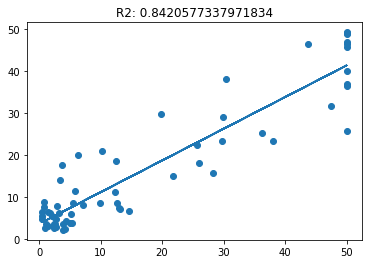

In [9]:
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.title('R2: ' + str(r2_score(y_test, y_pred)))

# Visualising leaves

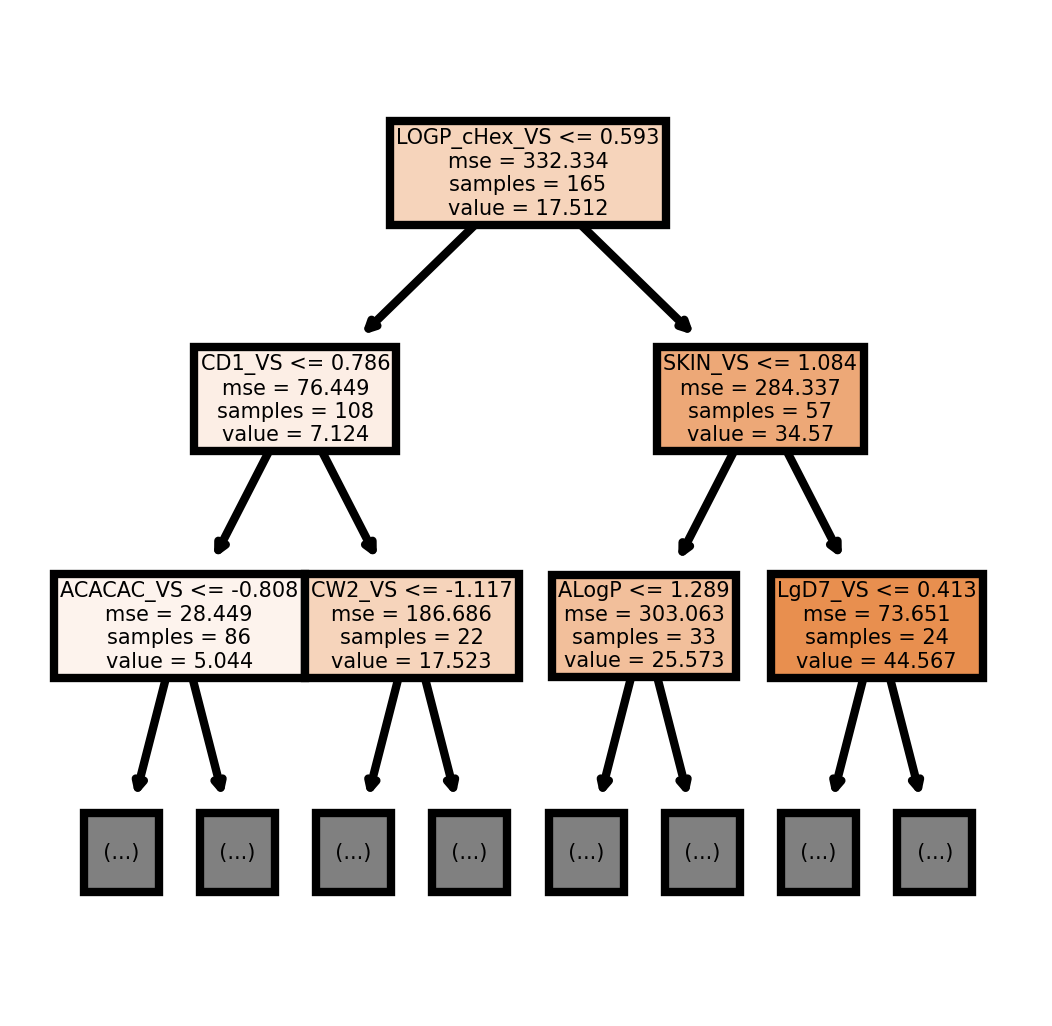

In [10]:
estimator = regressor.estimators_[2]

# print(estimator.feature_importances_)

allMerged.columns[2:]
allMerged.columns[1]


fn=allMerged.columns[2:]
cn=allMerged.columns[1]
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=600)
tree.plot_tree(estimator,
               feature_names = fn, 
               class_names=cn,
               filled = True,
               max_depth=2,
               fontsize = 2.5);
fig.savefig('RandomForest_PP_Clearance_classifier.png')